# BSPF Analysis - ML

In [1]:
import os
import pandas as pd
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

In [2]:
from functions.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
from functions.compute_linear_regression import __compute_linear_regression

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

# config['path_to_data'] = data_path+"BSPF/data/ACC/"
config['path_to_data'] = data_path+"BSPF/data/"

config['path_to_catalogs'] = data_path+"BSPF/data/catalogs/"

config['path_to_figs'] = data_path+"BSPF/figures/"

config['catalog'] = ""

config['save'] = False

config['translation_type'] = "ACC"

# config['catalog'] = "BSPF_catalog_20221001_20230930_all.pkl"
config['catalog'] = "BSPF_catalog_20221001_20231001_all.pkl"

## Load Data

In [5]:
# data_amax_disp = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_amax_disp.pkl")

# data_snr = pd.read_pickle(config['path_to_data']+"bspf_analysisdata_snr_disp.pkl")

In [6]:
data_amax = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_amax_{config['translation_type']}.pkl")

data_snr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_snr_{config['translation_type']}.pkl")

data_adr = pd.read_pickle(config['path_to_data']+f"bspf_analysisdata_adr_{config['translation_type']}.pkl")

In [7]:
data_amax_cosum_6 = data_amax[data_amax.CoincidenceSum == 6]

data_snr_cosum_6 = data_snr[data_snr.CoincidenceSum == 6]

In [8]:
## read data frame of selected triggered events
events = pd.read_pickle(config['path_to_catalogs']+config['catalog'])

events['Hdistance_km'] = np.sqrt((events.depth/1000)**2 + events.distances_km**2)

events_not_triggered = events.reset_index().rename(columns={"index":"origin"}).copy()

events_not_triggered = events_not_triggered[~events_not_triggered.origin.isin(data_amax.origin.values)]

In [9]:
events.shape, events_not_triggered.shape

((10841, 8), (10441, 9))

## Modify Data

Filter data

In [10]:
## reject nan values
print(f" AMAX:    all: {data_amax.origin.size} no_nan: {data_amax.origin.dropna().shape[0]}")
data_amax.origin.dropna(inplace=True)

print(f" SNR:     all: {data_snr.origin.size} no_nan: {data_snr.origin.dropna().shape[0]}")
data_snr.origin.dropna(inplace=True)

print(f" CoSum6:  all: {data_amax_cosum_6.origin.size} no_nan: {data_amax_cosum_6.origin.dropna().shape[0]}")
data_amax_cosum_6.origin.dropna(inplace=True)

 AMAX:    all: 400 no_nan: 400
 SNR:     all: 389 no_nan: 389
 CoSum6:  all: 117 no_nan: 117


/tmp/ipykernel_426178/1513122775.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_amax_cosum_6.origin.dropna(inplace=True)


In [11]:
def __ml_fit(X, a, b, c):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b*hdist - c )


def __predict_amplitude(X, a, b, c):
    mag, hdist = X
    return 10**( mag - a*np.log10(hdist) - b*hdist - c )


def __predict_magnitude(X, a, b, c):
    amax, hdist = X
    return np.log10(amax) + a*np.log10(hdist)+ b*hdist + c


def __predict_local_magnitude(X, a, b, c):
    amp, hdist = X
    return np.log10(amp) + a*np.log10(hdist) + b*hdist + c


## Plots

In [12]:
# dataset = data_amax
dataset = data_amax_cosum_6



mag_grey = np.array(events_not_triggered.magnitude)
hdist_grey = np.array(events_not_triggered.Hdistance_km)

## select amplitude data
amax_n = np.array(dataset.BSPF__N_amax)
amax_e = np.array(dataset.BSPF__E_amax)
amax_z = np.array(dataset.BSPF__Z_amax)

amax_all = np.sqrt(amax_n**2 + amax_e**2 + amax_z**2) #/2 /np.pi
# amax_all = np.sqrt(amax_n**2 + amax_e**2) #/2 /np.pi
# amax_all = np.sqrt(amax_z**2) #/2 /np.pi

## create uncertainties
dataset['sigma'] = 1.0*np.ones(dataset.shape[0])
dataset['sigma'] = dataset.sigma.where(dataset.Magnitude < 1.0, 5.0)
dataset['sigma'] = dataset.sigma.where(dataset.Magnitude > 2.5, 0.3)
sigmas = np.array(dataset.sigma)

## select hypocentral distances and magnitudes
hdist_all = np.array(dataset.Hdistance_km)
mag_all = np.array(dataset.Magnitude)

## Append M62 event data
amax_all = np.append(amax_all, np.sqrt(5.4e-07**2 + 5.3e-07**2 + 1.4e-06**2)) #/2 /np.pi
mag_all = np.append(mag_all, 6.2)
hdist_all = np.append(hdist_all, 312)
sigmas = np.append(sigmas, 0.1)


## perform data fitting
# p0 = (1.11, 0.00189, 2.09)
popt_all, pcov_all = curve_fit(__ml_fit, (mag_all, hdist_all), amax_all,
                               check_finite=True,
                               p0=(-8., 0, 0),
                               bounds=([-10, -1, -10], [10, 1, 10]),
                               sigma=sigmas,
                              )

# popt_all[0], popt_all[1], popt_all[2] = 3.5, 0.0002, 3.0



## output the new laws
print(f"\n Ml =  log10(Amax) + {popt_all[0]:.2f} log10(R) + {popt_all[1]:.5f} * R + {popt_all[2]:.2f}")

## generate synthetic magnitudes
# syn_data_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[2])

## compute differences of magnitudes and synthetics
# diff_syn_all = mag_all-syn_data_all


## compute synthetic maximal amplitudes
amax_syn_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[1])

amax_syn_grey = __predict_amplitude((mag_grey, hdist_grey), popt_all[0], popt_all[1], popt_all[2])


## ______________________________________

a_all, b_all, c_all = popt_all[0], popt_all[1], popt_all[2]


hdist_syn = np.arange(1, 350+1, 0.5)
mag_syn = np.arange(-1, 6.5+0.1, 0.05)

amax_syn_all = np.zeros((len(hdist_syn), len(mag_syn)))

for i, h in enumerate(hdist_syn):
    for j, m in enumerate(mag_syn):
        amax_syn_all[i, j] = __predict_amplitude((m, h), a_all, b_all, c_all)


# ## blueSeis self-noise
# limit = 1.5e-7  #/2 /np.pi ## rad/s/Hz
# mag_limit_all = __predict_magnitude((limit, hdist_syn), a_all, b_all, c_all)


## blueSeis self-noise
limit_1hz = 1.0e-8  #/2 /np.pi ## rad/s/Hz
amax_limit_1hz = np.sqrt(3) * limit_1hz # adjust to amax definition
mag_limit_all_1hz = __predict_magnitude((amax_limit_1hz, hdist_syn), a_all, b_all, c_all)

limit_10hz = 3.0e-8  #/2 /np.pi ## rad/s/Hz
amax_limit_10hz = np.sqrt(3) * limit_10hz # adjust to amax definition
mag_limit_all_10hz = __predict_magnitude((amax_limit_10hz, hdist_syn), a_all, b_all, c_all)



 Ml =  log10(Amax) + 1.37 log10(R) + 0.00701 * R + 6.40


/tmp/ipykernel_426178/1080298139.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sigma'] = 1.0*np.ones(dataset.shape[0])
/tmp/ipykernel_426178/1080298139.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sigma'] = dataset.sigma.where(dataset.Magnitude < 1.0, 5.0)
/tmp/ipykernel_426178/1080298139.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

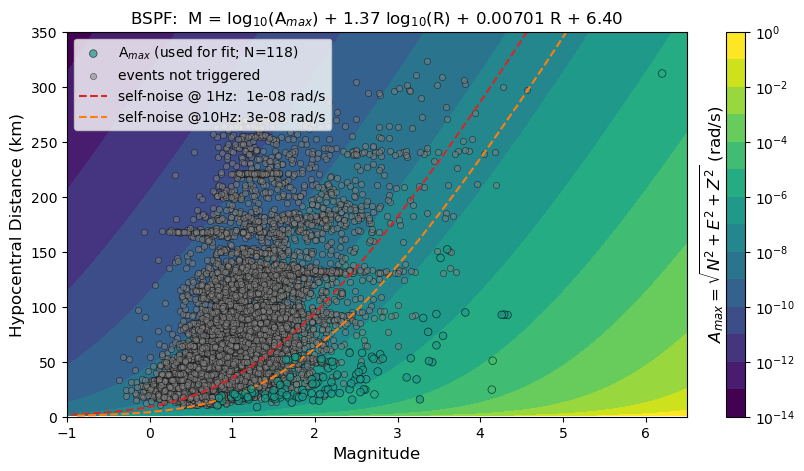

In [13]:
def __makeplot_all1():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('black')
    cmap.set_over('red')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    _lbl = r"A$_{max}$"
    ax.scatter(mag_all, hdist_all, c=amax_all, s=30, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.5,
               zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=f"{_lbl} (used for fit; N={len(amax_all)})")

    ax.scatter(mag_grey, hdist_grey, s=20, color="grey", edgecolors="black", lw=0.5,
               zorder=2, alpha=0.5, label="events not triggered")


    cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(mag_limit_all_1hz, hdist_syn, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(mag_limit_all_10hz, hdist_syn, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_xlim(-1, 6.5)
    ax.set_ylim(0, 350)

    cbar0 = plt.colorbar(cb0, ax=ax, extend='both')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{N^2 + E^2 + Z^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_xlabel("Magnitude", fontsize=font)
    ax.set_ylabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}"+ r" log$_{10}$" + "(R)" + f" + {popt_all[1]:.5f} R" + f" + {popt_all[2]:.2f}")

    ax.legend(loc=2)

    plt.show();
    return fig

fig = __makeplot_all1();

fig.savefig(config['path_to_figs']+"BSPF_ML_magnitudescale_overview1.png", format="png", dpi=200, bbox_inches='tight')


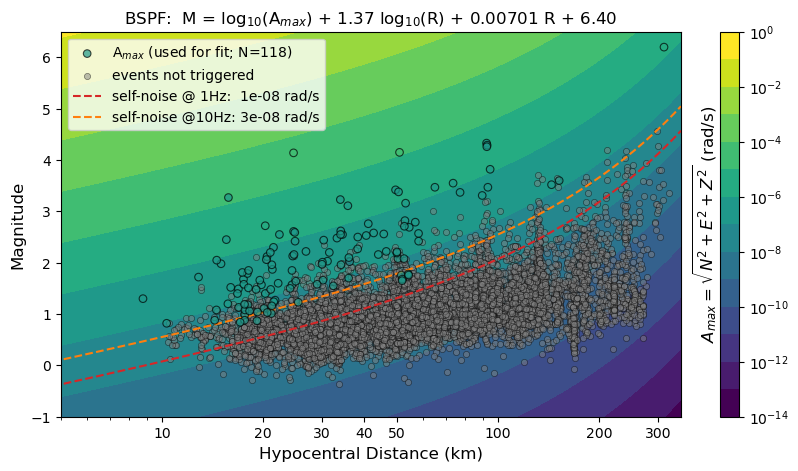

In [14]:
def __makeplot_all2():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('black')
    cmap.set_over('red')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    _lbl = r"A$_{max}$"
    ax.scatter(hdist_all, mag_all, c=amax_all, s=30, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.8,
               zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=f"{_lbl} (used for fit; N={len(amax_all)})")

    ax.scatter(hdist_grey, mag_grey, s=20, color="grey", edgecolors="black", lw=0.5,
               zorder=2, alpha=0.5, label="events not triggered")


    cb0 = ax.contourf(hdist_syn, mag_syn, amax_syn_all.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(hdist_syn, mag_limit_all_1hz, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(hdist_syn, mag_limit_all_10hz, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_ylim(-1, 6.5)
    ax.set_xlim(5, 350)

    ax.set_xscale("log")

    cbar0 = plt.colorbar(cb0, ax=ax, extend='both')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{N^2 + E^2 + Z^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_ylabel("Magnitude", fontsize=font)
    ax.set_xlabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}"+ r" log$_{10}$" + "(R)" + f" + {popt_all[1]:.5f} R" + f" + {popt_all[2]:.2f}")

    ax.legend(loc=2)

    ax.set_xticks([10, 20, 30, 40, 50, 100, 200, 300])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    plt.show();
    return fig

fig = __makeplot_all2();

fig.savefig(config['path_to_figs']+"BSPF_ML_magnitudescale_overview2.png", format="png", dpi=200, bbox_inches='tight')


### Single Components

In [15]:

a_n, b_n, c_n = popt_all[0], popt_all[1], popt_all[2]
a_e, b_e, c_e = popt_all[0], popt_all[1], popt_all[2]
a_z, b_z, c_z = popt_all[0], popt_all[1], popt_all[2]


hdist = np.arange(1, 200+1, 0.5)
mag = np.arange(-1, 6.5+0.1, 0.05)

amax_syn_n = np.zeros((len(hdist), len(mag)))
amax_syn_e = np.zeros((len(hdist), len(mag)))
amax_syn_z = np.zeros((len(hdist), len(mag)))

for i, h in enumerate(hdist):
    for j, m in enumerate(mag):
        amax_syn_n[i, j] = __predict_amplitude((m, h), a_n, b_n, c_n)
        amax_syn_e[i, j] = __predict_amplitude((m, h), a_e, b_e, c_e)
        amax_syn_z[i, j] = __predict_amplitude((m, h), a_z, b_z, c_z)


bspf_e = dataset.BSPF__E_amax
bspf_n = dataset.BSPF__N_amax
bspf_z = dataset.BSPF__Z_amax

bspf_mag = dataset.Magnitude
bspf_hdist = dataset.Hdistance_km

## blueSeis self-noise
limit_1hz = 1.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_1hz = __predict_magnitude((limit_1hz, hdist), a_all, b_all, c_all)

limit_10hz = 3.0e-8  #/2 /np.pi ## rad/s/Hz
mag_limit_all_10hz = __predict_magnitude((limit_10hz, hdist), a_all, b_all, c_all)


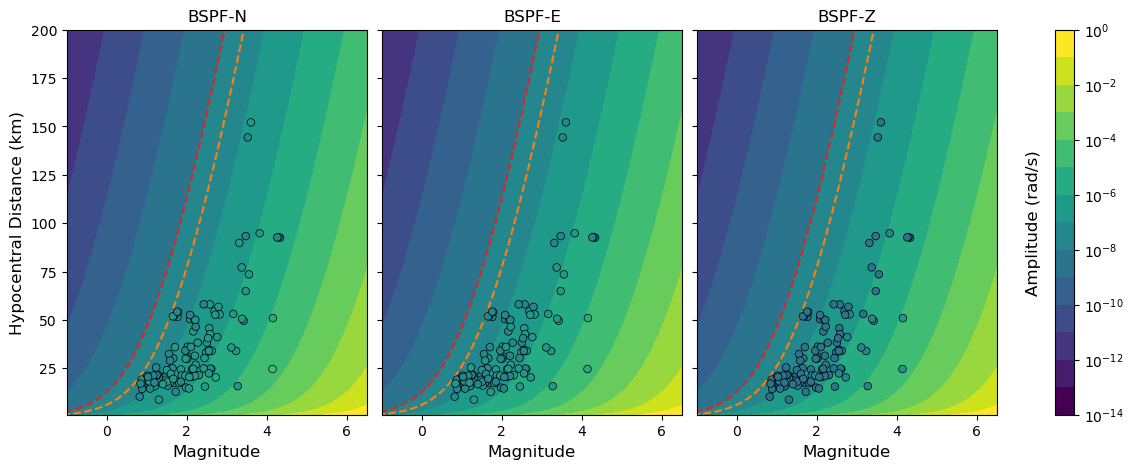

In [16]:
def __makeplot_single():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['rainbow'].resampled(11)
    # cmap.set_under('gray')


    amin_n, amax_n = min(amax_syn_n.reshape(1, amax_syn_n.size)[0]), max(amax_syn_n.reshape(1, amax_syn_n.size)[0])
    amin_e, amax_e = min(amax_syn_e.reshape(1, amax_syn_e.size)[0]), max(amax_syn_e.reshape(1, amax_syn_e.size)[0])
    amin_z, amax_z = min(amax_syn_z.reshape(1, amax_syn_z.size)[0]), max(amax_syn_z.reshape(1, amax_syn_z.size)[0])

    amin, amax = min(amin_n, amin_e, amin_z), max(amax_n, amax_e, amax_z)

    # lev = np.logspace(round(np.log10(amin),0), round(np.log10(amax),0), 10)
    # lev = np.logspace(amin, amax, levels)
    # lev_lbl = np.linspace(amin, amax, levels).astype(int)
    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    ax[0].scatter(bspf_mag, bspf_hdist, c=bspf_n, s=30, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                  norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    cb0 = ax[0].contourf(mag, hdist, amax_syn_n, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb1 = ax[1].scatter(bspf_mag, bspf_hdist, c=bspf_e, s=30, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                        norm=mpl.colors.LogNorm(vmin=amin, vmax=amax))
    ax[1].contourf(mag, hdist, amax_syn_e, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)


    cb2 = ax[2].scatter(bspf_mag, bspf_hdist, c=bspf_z, s=30, cmap=cmap, edgecolors="black", lw=0.5, zorder=3,
                        norm=mpl.colors.LogNorm(vmin=amin_z, vmax=amax_z))
    ax[2].contourf(mag, hdist, amax_syn_z, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)



    for jj in range(3):
        ax[jj].set_xlim(-1, 6.5)
        ax[jj].set_ylim(1, 200)
        ax[jj].plot(mag_limit_all_1hz, hdist, color="tab:red", ls="--")
        ax[jj].plot(mag_limit_all_10hz, hdist, color="tab:orange", ls="--")

    cbar0 = plt.colorbar(cb0, ax=ax, extend='min')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label("Amplitude (rad/s)", labelpad=-70, fontsize=font)

    ax[0].set_xlabel("Magnitude", fontsize=font)
    ax[0].set_ylabel("Hypocentral Distance (km)", fontsize=font)
    ax[1].set_xlabel("Magnitude", fontsize=font)
    ax[2].set_xlabel("Magnitude", fontsize=font)

    # ax[1].set_ylabel("Hypocentral Distance (km)")

#     law_n = f"N:  M = log$_{10}$(A$_{max}$)" + f" + {a_n:.2f}"+ r" log$_{10}$" + "(R)" + f"+ {b_n[1]:.5f} R" + f" + {b_c[2]:.2f}"

#     ax[0].set_title(r"")

    ax[0].set_title("BSPF-N")
    ax[1].set_title("BSPF-E")
    ax[2].set_title("BSPF-Z")

    plt.show();
    return fig

fig = __makeplot_single();

fig.savefig(config['path_to_figs']+"BSPF_ML_magnitudescale_components.png", format="png", dpi=200, bbox_inches='tight')


### Horizontal Axes

In [17]:
# dataset = data_amax
dataset = data_amax_cosum_6



mag_grey = np.array(events_not_triggered.magnitude)
hdist_grey = np.array(events_not_triggered.Hdistance_km)

## select amplitude data
amax_n = np.array(dataset.BSPF__N_amax)
amax_e = np.array(dataset.BSPF__E_amax)
amax_z = np.array(dataset.BSPF__Z_amax)

amax_all = np.sqrt(amax_n**2 + amax_e**2) #/2 /np.pi

## create uncertainties
dataset['sigma'] = 1.0*np.ones(dataset.shape[0])
dataset['sigma'] = dataset.sigma.where(dataset.Magnitude < 1.0, 5.0)
dataset['sigma'] = dataset.sigma.where(dataset.Magnitude > 2.5, 0.3)
sigmas = np.array(dataset.sigma)

## select hypocentral distances and magnitudes
hdist_all = np.array(dataset.Hdistance_km)
mag_all = np.array(dataset.Magnitude)

## Append M62 event data
amax_all = np.append(amax_all, np.sqrt(5.4e-07**2 + 5.3e-07**2 + 1.4e-06**2)) #/2 /np.pi
mag_all = np.append(mag_all, 6.2)
hdist_all = np.append(hdist_all, 312)
sigmas = np.append(sigmas, 0.1)


## perform data fitting
# p0 = (1.11, 0.00189, 2.09)
popt_all, pcov_all = curve_fit(__ml_fit, (mag_all, hdist_all), amax_all,
                               check_finite=True,
                               p0=(-8., 0, 0),
                               bounds=([-10, -1, -10], [10, 1, 10]),
                               sigma=sigmas,
                              )

# popt_all[0], popt_all[1], popt_all[2] = 3.5, 0.0002, 3.0



## output the new laws
print(f"\n Ml =  log10(Amax) + {popt_all[0]:.2f} log10(R) + {popt_all[1]:.5f} * R + {popt_all[2]:.2f}")

## generate synthetic magnitudes
# syn_data_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[2])

## compute differences of magnitudes and synthetics
# diff_syn_all = mag_all-syn_data_all


## compute synthetic maximal amplitudes
amax_syn_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[1])

amax_syn_grey = __predict_amplitude((mag_grey, hdist_grey), popt_all[0], popt_all[1], popt_all[2])


## ______________________________________

a_all, b_all, c_all = popt_all[0], popt_all[1], popt_all[2]


hdist_syn = np.arange(1, 350+1, 0.5)
mag_syn = np.arange(-1, 6.5+0.1, 0.05)

amax_syn_all = np.zeros((len(hdist_syn), len(mag_syn)))

for i, h in enumerate(hdist_syn):
    for j, m in enumerate(mag_syn):
        amax_syn_all[i, j] = __predict_amplitude((m, h), a_all, b_all, c_all)


# ## blueSeis self-noise
# limit = 1.5e-7  #/2 /np.pi ## rad/s/Hz
# mag_limit_all = __predict_magnitude((limit, hdist_syn), a_all, b_all, c_all)


## blueSeis self-noise
limit_1hz = 1.0e-8  #/2 /np.pi ## rad/s/Hz
amax_limit_1hz = np.sqrt(2) * limit_1hz # adjust to amax definition
mag_limit_all_1hz = __predict_magnitude((amax_limit_1hz, hdist_syn), a_all, b_all, c_all)

limit_10hz = 3.0e-8  #/2 /np.pi ## rad/s/Hz
amax_limit_10hz = np.sqrt(2) * limit_10hz # adjust to amax definition
mag_limit_all_10hz = __predict_magnitude((amax_limit_10hz, hdist_syn), a_all, b_all, c_all)



 Ml =  log10(Amax) + 1.37 log10(R) + 0.00695 * R + 6.40


/tmp/ipykernel_426178/3324938910.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sigma'] = 1.0*np.ones(dataset.shape[0])
/tmp/ipykernel_426178/3324938910.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sigma'] = dataset.sigma.where(dataset.Magnitude < 1.0, 5.0)
/tmp/ipykernel_426178/3324938910.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

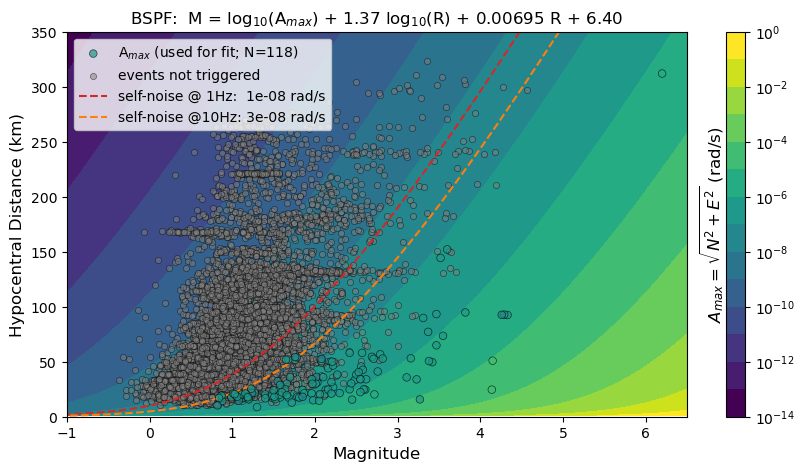

In [18]:
def __makeplot_all1():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('black')
    cmap.set_over('red')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    _lbl = r"A$_{max}$"
    ax.scatter(mag_all, hdist_all, c=amax_all, s=30, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.5,
               zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=f"{_lbl} (used for fit; N={len(amax_all)})")

    ax.scatter(mag_grey, hdist_grey, s=20, color="grey", edgecolors="black", lw=0.5,
               zorder=2, alpha=0.5, label="events not triggered")


    cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(mag_limit_all_1hz, hdist_syn, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(mag_limit_all_10hz, hdist_syn, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_xlim(-1, 6.5)
    ax.set_ylim(0, 350)

    cbar0 = plt.colorbar(cb0, ax=ax, extend='both')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{N^2 + E^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_xlabel("Magnitude", fontsize=font)
    ax.set_ylabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}"+ r" log$_{10}$" + "(R)" + f" + {popt_all[1]:.5f} R" + f" + {popt_all[2]:.2f}")

    ax.legend(loc=2)

    plt.show();
    return fig

fig = __makeplot_all1();

fig.savefig(config['path_to_figs']+"BSPF_ML_magnitudescale_horizontal1.png", format="png", dpi=200, bbox_inches='tight')


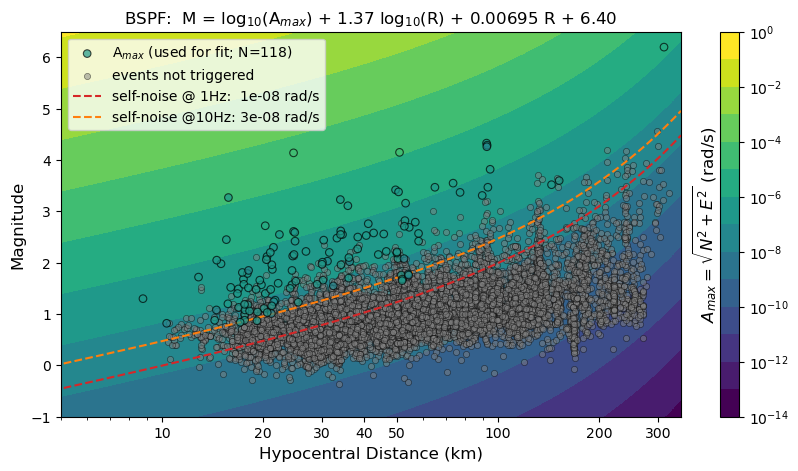

In [19]:
def __makeplot_all2():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('black')
    cmap.set_over('red')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    _lbl = r"A$_{max}$"
    ax.scatter(hdist_all, mag_all, c=amax_all, s=30, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.8,
               zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=f"{_lbl} (used for fit; N={len(amax_all)})")

    ax.scatter(hdist_grey, mag_grey, s=20, color="grey", edgecolors="black", lw=0.5,
               zorder=2, alpha=0.5, label="events not triggered")


    cb0 = ax.contourf(hdist_syn, mag_syn, amax_syn_all.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(hdist_syn, mag_limit_all_1hz, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(hdist_syn, mag_limit_all_10hz, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_ylim(-1, 6.5)
    ax.set_xlim(5, 350)

    ax.set_xscale("log")

    cbar0 = plt.colorbar(cb0, ax=ax, extend='both')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{N^2 + E^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_ylabel("Magnitude", fontsize=font)
    ax.set_xlabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}"+ r" log$_{10}$" + "(R)" + f" + {popt_all[1]:.5f} R" + f" + {popt_all[2]:.2f}")

    ax.legend(loc=2)

    ax.set_xticks([10, 20, 30, 40, 50, 100, 200, 300])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    plt.show();
    return fig

fig = __makeplot_all2();

fig.savefig(config['path_to_figs']+"BSPF_ML_magnitudescale_horizontal2.png", format="png", dpi=200, bbox_inches='tight')


### Vertcial Axes

In [20]:
# dataset = data_amax
dataset = data_amax_cosum_6



mag_grey = np.array(events_not_triggered.magnitude)
hdist_grey = np.array(events_not_triggered.Hdistance_km)

## select amplitude data
amax_n = np.array(dataset.BSPF__N_amax)
amax_e = np.array(dataset.BSPF__E_amax)
amax_z = np.array(dataset.BSPF__Z_amax)

amax_all = np.sqrt(amax_z**2) #/2 /np.pi

## create uncertainties
dataset['sigma'] = 1.0*np.ones(dataset.shape[0])
dataset['sigma'] = dataset.sigma.where(dataset.Magnitude < 1.0, 5.0)
dataset['sigma'] = dataset.sigma.where(dataset.Magnitude > 2.5, 0.3)
sigmas = np.array(dataset.sigma)

## select hypocentral distances and magnitudes
hdist_all = np.array(dataset.Hdistance_km)
mag_all = np.array(dataset.Magnitude)

## Append M62 event data
amax_all = np.append(amax_all, np.sqrt(5.4e-07**2 + 5.3e-07**2 + 1.4e-06**2)) #/2 /np.pi
mag_all = np.append(mag_all, 6.2)
hdist_all = np.append(hdist_all, 312)
sigmas = np.append(sigmas, 0.1)


## perform data fitting
# p0 = (1.11, 0.00189, 2.09)
popt_all, pcov_all = curve_fit(__ml_fit, (mag_all, hdist_all), amax_all,
                               check_finite=True,
                               p0=(-8., 0, 0),
                               bounds=([-10, -1, -10], [10, 1, 10]),
                               sigma=sigmas,
                              )

# popt_all[0], popt_all[1], popt_all[2] = 3.5, 0.0002, 3.0



## output the new laws
print(f"\n Ml =  log10(Amax) + {popt_all[0]:.2f} log10(R) + {popt_all[1]:.5f} * R + {popt_all[2]:.2f}")

## generate synthetic magnitudes
# syn_data_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[2])

## compute differences of magnitudes and synthetics
# diff_syn_all = mag_all-syn_data_all


## compute synthetic maximal amplitudes
amax_syn_all = __predict_amplitude((mag_all, hdist_all), popt_all[0], popt_all[1], popt_all[1])

amax_syn_grey = __predict_amplitude((mag_grey, hdist_grey), popt_all[0], popt_all[1], popt_all[2])


## ______________________________________

a_all, b_all, c_all = popt_all[0], popt_all[1], popt_all[2]


hdist_syn = np.arange(1, 350+1, 0.5)
mag_syn = np.arange(-1, 6.5+0.1, 0.05)

amax_syn_all = np.zeros((len(hdist_syn), len(mag_syn)))

for i, h in enumerate(hdist_syn):
    for j, m in enumerate(mag_syn):
        amax_syn_all[i, j] = __predict_amplitude((m, h), a_all, b_all, c_all)


# ## blueSeis self-noise
# limit = 1.5e-7  #/2 /np.pi ## rad/s/Hz
# mag_limit_all = __predict_magnitude((limit, hdist_syn), a_all, b_all, c_all)


## blueSeis self-noise
limit_1hz = 1.0e-8  #/2 /np.pi ## rad/s/Hz
amax_limit_1hz = np.sqrt(1) * limit_1hz # adjust to amax definition
mag_limit_all_1hz = __predict_magnitude((amax_limit_1hz, hdist_syn), a_all, b_all, c_all)

limit_10hz = 3.0e-8  #/2 /np.pi ## rad/s/Hz
amax_limit_10hz = np.sqrt(1) * limit_10hz # adjust to amax definition
mag_limit_all_10hz = __predict_magnitude((amax_limit_10hz, hdist_syn), a_all, b_all, c_all)



 Ml =  log10(Amax) + 1.42 log10(R) + 0.00652 * R + 6.42


/tmp/ipykernel_426178/3965863304.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sigma'] = 1.0*np.ones(dataset.shape[0])
/tmp/ipykernel_426178/3965863304.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sigma'] = dataset.sigma.where(dataset.Magnitude < 1.0, 5.0)
/tmp/ipykernel_426178/3965863304.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

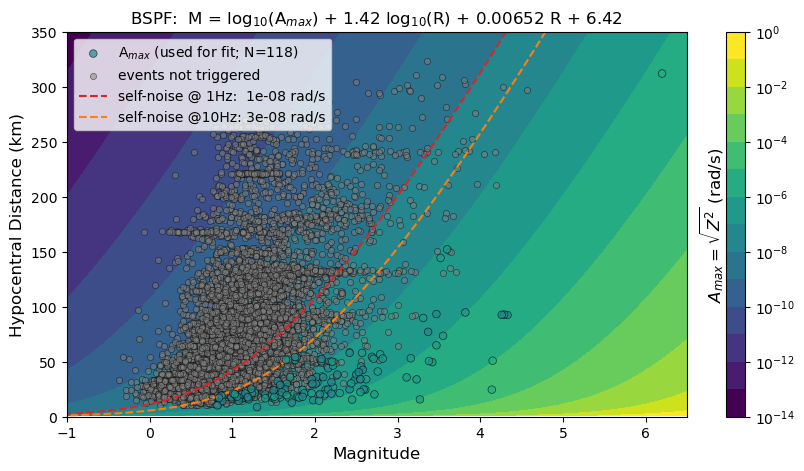

In [21]:
def __makeplot_all1():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('black')
    cmap.set_over('red')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    _lbl = r"A$_{max}$"
    ax.scatter(mag_all, hdist_all, c=amax_all, s=30, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.5,
               zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=f"{_lbl} (used for fit; N={len(amax_all)})")

    ax.scatter(mag_grey, hdist_grey, s=20, color="grey", edgecolors="black", lw=0.5,
               zorder=2, alpha=0.5, label="events not triggered")


    cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(mag_limit_all_1hz, hdist_syn, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(mag_limit_all_10hz, hdist_syn, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_xlim(-1, 6.5)
    ax.set_ylim(0, 350)

    cbar0 = plt.colorbar(cb0, ax=ax, extend='both')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{Z^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_xlabel("Magnitude", fontsize=font)
    ax.set_ylabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}"+ r" log$_{10}$" + "(R)" + f" + {popt_all[1]:.5f} R" + f" + {popt_all[2]:.2f}")

    ax.legend(loc=2)

    plt.show();
    return fig

fig = __makeplot_all1();

fig.savefig(config['path_to_figs']+"BSPF_ML_magnitudescale_vertical1.png", format="png", dpi=200, bbox_inches='tight')


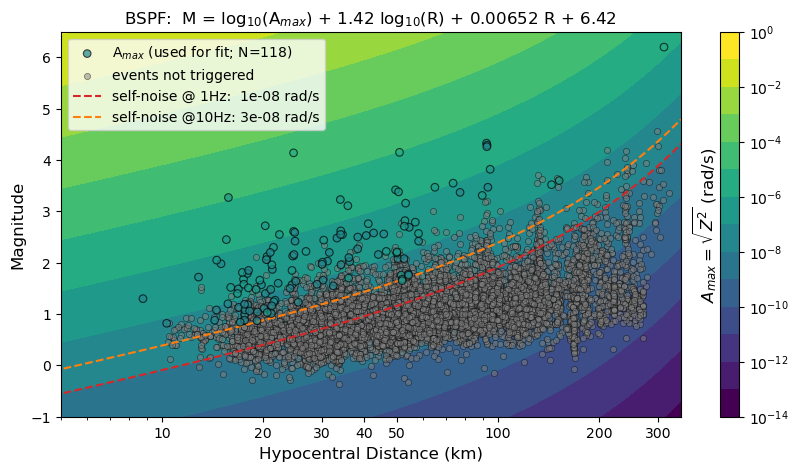

In [22]:
def __makeplot_all2():

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from matplotlib.ticker import LogFormatterExponent # <-- one new import here

    fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)

    font = 12

    plt.subplots_adjust(wspace=0.05)

    cmap = mpl.colormaps['viridis'].resampled(14)
    # cmap = mpl.colormaps['jet'].resampled(28)
    cmap.set_under('black')
    cmap.set_over('red')


    # amin_all, amax_all = min(amax_syn_all.reshape(1, amax_syn_all.size)[0]), max(amax_syn_all.reshape(1, amax_syn_all.size)[0])

    lev = np.array([1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0])

    amin, amax = min(lev), max(lev)

    lev_lbl = np.log10(lev)

    _lbl = r"A$_{max}$"
    ax.scatter(hdist_all, mag_all, c=amax_all, s=30, cmap=cmap, edgecolors="black", alpha=0.7, lw=0.8,
               zorder=3, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), label=f"{_lbl} (used for fit; N={len(amax_all)})")

    ax.scatter(hdist_grey, mag_grey, s=20, color="grey", edgecolors="black", lw=0.5,
               zorder=2, alpha=0.5, label="events not triggered")


    cb0 = ax.contourf(hdist_syn, mag_syn, amax_syn_all.T, cmap=cmap, norm=mpl.colors.LogNorm(vmin=amin, vmax=amax), levels=lev)
    # cb0 = ax.contourf(mag_syn, hdist_syn, amax_syn_all, cmap=cmap, levels=lev)

    # ax.plot(mag_limit_all, hdist_syn, color="tab:red", ls="--", label=f"self-noise: {limit} rad/s")
    ax.plot(hdist_syn, mag_limit_all_1hz, color="tab:red", ls="--", label=f"self-noise @ 1Hz:  {limit_1hz} rad/s")
    ax.plot(hdist_syn, mag_limit_all_10hz, color="tab:orange", ls="--", label=f"self-noise @10Hz: {limit_10hz} rad/s")

    ax.set_ylim(-1, 6.5)
    ax.set_xlim(5, 350)

    ax.set_xscale("log")

    cbar0 = plt.colorbar(cb0, ax=ax, extend='both')
    # cbar0.set_ticklabels(lev_lbl)
    cbar0.set_label(r"$A_{max} = \sqrt{Z^2}$ (rad/s)", labelpad=-70, fontsize=font)

    ax.set_ylabel("Magnitude", fontsize=font)
    ax.set_xlabel("Hypocentral Distance (km)", fontsize=font)

    ax.set_title(r"BSPF:  M = log$_{10}$(A$_{max}$)" + f" + {popt_all[0]:.2f}"+ r" log$_{10}$" + "(R)" + f" + {popt_all[1]:.5f} R" + f" + {popt_all[2]:.2f}")

    ax.legend(loc=2)

    ax.set_xticks([10, 20, 30, 40, 50, 100, 200, 300])
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    plt.show();
    return fig

fig = __makeplot_all2();

fig.savefig(config['path_to_figs']+"BSPF_ML_magnitudescale_vertcial2.png", format="png", dpi=200, bbox_inches='tight')
